In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using AtomsBuilder
using ComponentArrays
using DFTK
using ForwardDiff
using LinearAlgebra
using Plots
using PseudoPotentialData
using Random
using Unitful
using UnitfulAtomic

  Activating project at `~/git/tutorial-cecam-workshop-dftk-2025`


# Defining a custom XC functional in DftFunctionals.jl

It is easy to define a new exchange-correlation functional and use it with DFTK.
Defining an energy expression is sufficient: We will use ForwardDiff
to automatically compute exchange-correlation energy derivatives of 
- first-order (for SCF): the XC potential $V_\text{xc} = \frac{\partial E_\text{xc}}{\partial \rho}$, and
- second-order (for DFPT): the XC kernel $\frac{\partial V_\text{xc}}{\partial \rho}$, and the potential-parameter-derivative $\frac{\partial V_\text{xc}}{\partial \theta}$

(*Technical remark: Currently this functionality is limited to GGA-type functionals.*)

In this notebook, our running example will be the [BEEF (Bayesian Error Estimation Functional)](https://doi.org/10.1103/PhysRevLett.95.216401). The BEEF is an example which comes with an associated parameter uncertainty modelled as a Gaussian distribution $\theta \sim \mathcal{N}(\theta_\text{bf}, \Sigma_\theta)$, where
- the mean $\theta_\text{bf}$ corresponds to "best-fit" parameters
- the uncertainty $\Sigma_\theta$ is the covariance matrix, calibrated against experimental relative energies on a small dataset.

What we will do here:
- implement this GGA functional from scratch
- run self-consistent DFT calculations with it in DFTK
- compute DFPT results to obtain self-consistent parameter derivatives of observables
- propagate uncertainties to lattice constants and band structures (including relaxation effects)

In [2]:
using DftFunctionals

"""
The BEEF ensemble is described by a Gaussian distribution
    in parameters θ ∼ N(θ_bf, LLᵀ)
    or equivalently: θ = θ_bf + L * α
    where α is standard normal.

From the paper:
    `Bayesian Error Estimation in Density-Functional Theory` (2005)
    J. J. Mortensen, K. Kaasbjerg, S. L. Frederiksen, J. K. Nørskov,
    J. P. Sethna, and K. W. Jacobsen
    DOI: https://doi.org/10.1103/PhysRevLett.95.216401
"""
function params_beef_2005()
    θ_bf = [1.0008, 0.1926, 1.8962]  # After Eq (4)
    L = [
        0.066 0.055 -0.034 
       -0.812 0.206  0.007 
        1.996 0.082  0.004
    ]  # Eq (5)
    (; θ_bf, L)
end

struct BeefExchange{T} <: Functional{:gga,:x} where {T}
    θ::T
    identifier::Symbol
end
BeefExchange(θ) = BeefExchange(θ, :gga_x_beef_custom)

DftFunctionals.parameters(beefx::BeefExchange) = beefx.θ
DftFunctionals.identifier(beefx::BeefExchange) = beefx.identifier

function DftFunctionals.change_parameters(beefx::BeefExchange, parameters::AbstractArray;
    keep_identifier=false)
    keep_identifier ? BeefExchange(parameters, beefx.identifier) : BeefExchange(parameters)
end

function f_x_beef(s, θ)
    sum(enumerate(θ)) do (i, θi)
        θi * (s / (one(s) + s))^(2i - 2)  # Eq (3)
    end
end

function DftFunctionals.energy(beefx::BeefExchange, ρ::T, σ::U) where {T<:Number,U<:Number}
    TT = DftFunctionals.arithmetic_type(beefx, T, U)
    s = sqrt(σ) / (ρ^(4 / 3) * 2cbrt(3π^2))
    res = DftFunctionals.energy(LdaExchange(), ρ) * f_x_beef(s, beefx.θ)
    TT(res)
end

make_beef(θ) = [BeefExchange(θ), DftFunctional(Val(:gga_c_pbe))]

make_beef (generic function with 1 method)

Let's visualize the exchange-enhancement factor ensemble (as Fig 1. in https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.95.216401)

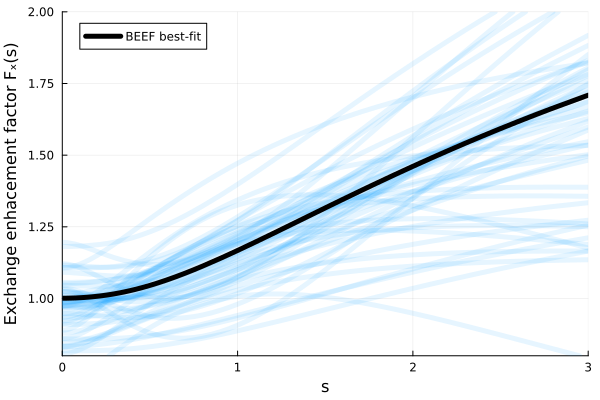

In [3]:
let 
    params = params_beef_2005()
    rng = MersenneTwister(1234)
    n_samples = 50
    α = randn(rng, 3, n_samples)
    δθ_ensemble = params.L * α
    fig_fx_ensemble = plot(xlim=(0,3), ylim=(0.8, 2.0), xlabel="s", ylabel="Exchange enhacement factor Fₓ(s)")
    for δθ in eachcol(δθ_ensemble)
        plot!(fig_fx_ensemble, s -> f_x_beef(s, params.θ_bf + δθ), label=nothing,
        color=1, linealpha=0.1, lw=5)
    end
    plot!(fig_fx_ensemble, s -> f_x_beef(s, params.θ_bf), label="BEEF best-fit",
    linewidth=5, color=:black)
    fig_fx_ensemble
end

## Using the custom XC functional in DFTK

In [4]:
params = params_beef_2005()
make_functionals(θ) = make_beef(θ)
functionals = make_functionals(params.θ_bf)

2-element Vector{Functional{:gga}}:
 gga_x_beef_custom
 gga_c_pbe

In [5]:
a0_beef = 10.328164895118894  # From a prior geometry relaxation
a0 = a0_beef
system = bulk(:Si; a=a0_beef * u"bohr")

# Set up DFT model
pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
(; lattice, atoms, positions) = DFTK.parse_system(system, pseudopotentials)
model = model_DFT(lattice, atoms, positions; functionals, temperature=1e-3)
symmetries = model.symmetries

# Discretization
Ecut = recommended_cutoff(model).Ecut
kgrid = (8, 8, 8)
basis = PlaneWaveBasis(model; Ecut, kgrid)

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 6
    num. fft   threads   : 1

    Ecut                 : 18.0 Ha
    fft_size             : (32, 32, 32), 32768 total points
    kgrid                : MonkhorstPack([8, 8, 8])
    num.   red. kpoints  : 512
    num. irred. kpoints  : 29

    Discretized Model(gga_x_beef_custom+gga_c_pbe, 3D):
        lattice (in Bohr)    : [0         , 5.16408   , 5.16408   ]
                               [5.16408   , 0         , 5.16408   ]
                               [5.16408   , 5.16408   , 0         ]
        unit cell volume     : 275.43 Bohr³
    
        atoms                : Si₂
        pseudopot. family    : PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
    
        num. electrons       : 8
        spin polarization    : none
        temperature          : 0.001 Ha
        smearing             : DFTK.

In [6]:
scfres = self_consistent_field(basis; tol=1e-8);

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450576656433                   -0.96    4.3    5.98s
  2   -8.452302096353       -2.76       -1.48    1.0    3.14s
  3   -8.452534100081       -3.63       -2.84    1.7    565ms
  4   -8.452557919629       -4.62       -3.29    3.4    1.07s
  5   -8.452557971401       -7.29       -3.66    1.1    398ms
  6   -8.452557993750       -7.65       -4.39    2.3    447ms
  7   -8.452557995406       -8.78       -4.96    2.2    479ms
  8   -8.452557995481      -10.13       -5.68    2.2    803ms
  9   -8.452557995485      -11.43       -6.32    2.6    961ms
 10   -8.452557995485      -12.41       -6.64    2.4    922ms
 11   -8.452557995485   +  -12.67       -7.03    1.3    753ms
 12   -8.452557995485      -13.18       -7.86    1.6    703ms
 13   -8.452557995485      -13.97       -8.56    2.9    1.31s


In [7]:
compute_stresses_cart(scfres)

3×3 StaticArraysCore.SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
 9.76194e-7  -5.64689e-22   0.0
 0.0          9.76194e-7   -5.64689e-22
 0.0          0.0           9.76194e-7

## Computing XC parameter sensitivities by AD-DFPT

In [8]:
function setup_basis(a, θ; Ecut, kgrid, temperature=1e-3)
    T = promote_type(eltype(a), eltype(θ))
    lattice_new = (a / a0) * lattice
    model_new = model_DFT(T.(lattice_new), atoms, positions;
                          functionals=make_functionals(θ),
                          symmetries, temperature)
    basis_new = PlaneWaveBasis(model_new; Ecut, kgrid)
end

setup_basis (generic function with 1 method)

In [9]:
function hellmann_feynman_observables(a, θ; Ecut, kgrid, tol)
    # 1. Setup
    basis = setup_basis(a, θ; Ecut, kgrid)

    # 2. Solve
    scfres = self_consistent_field(basis; tol)

    # 3. Postprocess
    grads = ForwardDiff.gradient(ComponentVector(; a, θ)) do x
        basis_new = setup_basis(x.a, x.θ; Ecut, kgrid)
        ρ = compute_density(basis_new, scfres.ψ, scfres.occupation)
        (; energies) = DFTK.energy(basis_new, scfres.ψ, scfres.occupation;
                                   ρ, scfres.eigenvalues, scfres.εF)
        energies.total
    end

    grads
end

hellmann_feynman_observables (generic function with 1 method)

In [10]:
hellmann_feynman_observables(a0, params.θ_bf; Ecut, kgrid, tol=1e-6)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450558670275                   -0.96    4.4    932ms
  2   -8.452301066834       -2.76       -1.48    1.0    707ms
  3   -8.452534397377       -3.63       -2.84    1.8    1.17s
  4   -8.452557913557       -4.63       -3.33    3.3    3.51s
  5   -8.452557973801       -7.22       -3.73    1.4    2.29s
  6   -8.452557993969       -7.70       -4.44    2.3    3.04s
  7   -8.452557995424       -8.84       -4.94    2.3    2.60s
  8   -8.452557995481      -10.24       -5.33    1.8    2.16s
  9   -8.452557995485      -11.48       -5.90    1.4    1.26s
 10   -8.452557995485      -12.18       -6.28    2.2    2.73s


ComponentVector{Float64}(a = 7.800673557889493e-5, θ = [-2.6142646814684505, -0.20714838977596434, -0.022445217578673262])

In [11]:
hess = ForwardDiff.derivative(
    a -> hellmann_feynman_observables(a, params.θ_bf; Ecut, kgrid, tol=1e-6),
    a0
)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450580398808                   -0.96    4.3    1.93s
  2   -8.452303202113       -2.76       -1.48    1.0    1.27s
  3   -8.452533992181       -3.64       -2.84    1.8    1.76s
  4   -8.452557915254       -4.62       -3.32    3.4    2.70s
  5   -8.452557974726       -7.23       -3.70    1.4    1.74s
  6   -8.452557994034       -7.71       -4.45    2.3    1.08s
  7   -8.452557995422       -8.86       -5.11    2.3    1.22s
  8   -8.452557995478      -10.26       -5.76    2.5    1.72s
  9   -8.452557995485      -11.12       -6.57    2.9    1.12s
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      58.1   6.69s  Non-interacting
   1        0       1       -0.86     42.1   16.6s  
   2        0       2       -2.63     36.2   

ComponentVector{Float64}(a = 0.07012570058924873, θ = [0.15020949261150096, -0.019620938110169586, -0.005618489137103879])

In [12]:
lattice_constant_gradient = hess.a \ hess.θ  # Implicit derivative of relaxed lattice constant w.r.t. θ

3-element Vector{Float64}:
  2.142003450223358
 -0.2797966786114042
 -0.08012025676596625

## Predictive XC uncertainty in the lattice constant

We compute a linearized Gaussian pushfoward uncertainty
$$
\mathcal{N}(\theta_0, LL^\top) \to \mathcal{N}(a^\star(\theta_0), J LL^\top J^\top)
$$
where $J = \frac{\partial a^\star}{\partial\theta}\lvert_{\theta_0}$ is the implicit derivative of the lattice constant as a function of the XC parameters, evaluated at mean parameters $\theta_0$.

In [13]:
lattice_constant_uncertainty = norm(params.L'lattice_constant_gradient)

0.22814008105418995

In [14]:
a0_exp = austrip(5.422u"angstrom")

10.246095047720924

In [15]:
(a0 - a0_exp) / a0_exp

0.008009865906545966

In [16]:
println("Predicted lattice constant:    ", uconvert(u"angstrom", a0 * u"bohr"))
println("Experimental lattice constant: ", uconvert(u"angstrom", a0_exp * u"bohr"))
println("True error:                    ", uconvert(u"angstrom", (a0 - a0_exp) * u"bohr"))
println("Uncertainty estimate:          ", uconvert(u"angstrom", lattice_constant_uncertainty * u"bohr"))

Predicted lattice constant:    5.465429492945291 Å
Experimental lattice constant: 5.421999999999999 Å
True error:                    0.04342949294529222 Å
Uncertainty estimate:          0.12072653178744058 Å


## Propagating uncertainty to band structures

In [17]:
bands = compute_bands(scfres);
propertynames(bands)

(:basis, :ψ, :eigenvalues, :ρ, :εF, :occupation, :diagonalization, :kinter)

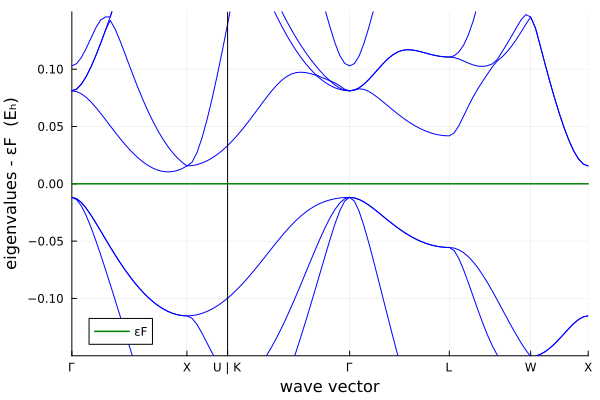

In [18]:
plot_bandstructure(bands)

To apply the same strategy as above, we are now interested in the derivative
of the whole band structure $\varepsilon_{n\mathbf{k}}$ with respect to parameters $\theta$.

Now this can be combined to the total gradient of the *equilibrium* band gap $\varepsilon_{n\textbf{k}}^\text{relaxed}(\theta) := \varepsilon_{n\textbf{k}}(a^\star(\theta), \theta)$ as
$$
\begin{align*}
\frac{\partial \varepsilon_{n\textbf{k}}^\text{relaxed}}{\partial \theta}
=
\frac{\partial \varepsilon_{n\textbf{k}}}{\partial \theta} + \frac{\partial \varepsilon_{n\textbf{k}}}{\partial a} \frac{\partial a^\star}{\partial \theta}
\end{align*}
$$


In [19]:
include("compute_bands_forwarddiff.jl")

compute_bands_forwarddiff (generic function with 2 methods)

In [20]:
kgrid_bands = ExplicitKpoints(bands.kinter)

ExplicitKpoints with 109 k-points

In [21]:
function bandstructure(a, θ)
    basis = setup_basis(a, θ; Ecut, kgrid)
    scfres = self_consistent_field(basis; tol=1e-6)
    bands = compute_bands_forwarddiff(basis, kgrid_bands; scfres.ρ, tol=1e-6)
    reduce(hcat, bands.eigenvalues) .- scfres.εF
end

bandstructure (generic function with 1 method)

In [22]:
b = bandstructure(a0, params.θ_bf)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450546807520                   -0.96    4.3    1.92s
  2   -8.452300460451       -2.76       -1.48    1.0    2.02s
  3   -8.452533722403       -3.63       -2.84    1.8    1.60s
  4   -8.452557912549       -4.62       -3.31    3.3    2.15s
  5   -8.452557974432       -7.21       -3.71    1.4    1.48s
  6   -8.452557994080       -7.71       -4.46    2.3    1.44s
  7   -8.452557995410       -8.88       -5.08    2.3    1.64s
  8   -8.452557995480      -10.16       -6.00    2.6    940ms
  9   -8.452557995485      -11.23       -6.59    3.2    1.03s


17×109 Matrix{Float64}:
 -0.446911   -0.446636   -0.445813   …  -0.296894   -0.297156   -0.297245
 -0.011817   -0.013815   -0.0194247     -0.296894   -0.297156   -0.297245
 -0.011817   -0.013007   -0.0163546     -0.118312   -0.115996   -0.115181
 -0.011817   -0.013007   -0.0163546     -0.118312   -0.115996   -0.115181
  0.0810666   0.0803977   0.0784459      0.0215391   0.0171307   0.0156188
  0.0810666   0.0825959   0.0869608  …   0.0215391   0.0171307   0.0156188
  0.0810666   0.0825959   0.0869608      0.341754    0.349804    0.352234
  0.10285     0.104806    0.110238       0.341754    0.349804    0.352234
  0.270986    0.268752    0.26256        0.380114    0.386389    0.390026
  0.270986    0.271291    0.272207       0.380114    0.386389    0.390026
  0.279723    0.280938    0.284528   …   0.450299    0.447599    0.44512
  0.399551    0.400029    0.401465       0.450299    0.447599    0.44512
  0.399551    0.400029    0.401465       0.475351    0.462962    0.459116
  0.399551    

In [23]:
dbands = ForwardDiff.jacobian(
    θ -> bandstructure(a0, θ),
    params.θ_bf
)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450570815829                   -0.96    4.3    1.72s
  2   -8.452303371848       -2.76       -1.48    1.0    743ms
  3   -8.452534946906       -3.64       -2.84    1.8    869ms
  4   -8.452557921638       -4.64       -3.34    3.3    1.09s
  5   -8.452557973580       -7.28       -3.73    1.4    760ms
  6   -8.452557994022       -7.69       -4.41    2.3    892ms
  7   -8.452557995421       -8.85       -4.86    2.3    797ms
  8   -8.452557995479      -10.24       -5.24    1.5    691ms
  9   -8.452557995485      -11.22       -5.76    1.5    768ms
 10   -8.452557995486      -12.14       -6.10    1.7    1.27s
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      54.4   1.38s  Non-interacting
   1        0       1       -1.47   

1853×3 Matrix{Float64}:
 -0.0174548   -0.00572072   -0.00261785
 -0.0385385   -0.0153719    -0.00509513
 -0.0385385   -0.0153719    -0.00509513
 -0.0385385   -0.0153719    -0.00509513
 -0.00709483  -0.00024743   -0.00265457
 -0.00709483  -0.00024743   -0.00265457
 -0.00709483  -0.000247432  -0.00265457
 -0.0409962   -0.00890014   -0.00320094
 -0.00491454  -0.000634414  -0.00300932
 -0.00491454  -0.000634414  -0.00300932
  ⋮                         
 -0.016671    -0.0101027    -0.00208639
 -0.016671    -0.0101027    -0.00208639
 -0.00831732  -0.0013572    -0.00325366
 -0.00831732  -0.0013572    -0.00325366
 -0.0177647   -0.00316214    0.000539151
 -0.0177647   -0.00316214    0.000539151
  0.0236095    0.0138704     0.00584224
  0.0236095    0.0138704     0.00584224
  0.0482035    0.0189446     0.00831284

In [24]:
dbands_reshaped = reshape(dbands, size(b)..., length(params.θ_bf))

17×109×3 Array{Float64, 3}:
[:, :, 1] =
 -0.0174548   -0.0174731   -0.0175279    …  -0.0286571   -0.028609
 -0.0385385   -0.0385742   -0.0386648       -0.0286571   -0.028609
 -0.0385385   -0.0379614   -0.0364732       -0.0189491   -0.0194735
 -0.0385385   -0.0379614   -0.0364732       -0.0189491   -0.0194735
 -0.00709483  -0.00673078  -0.00569575       0.0232659    0.0237951
 -0.00709483  -0.00767645  -0.00917696   …   0.0232659    0.0237951
 -0.00709483  -0.00767645  -0.00917696      -0.0256815   -0.0263868
 -0.0409962   -0.0409642   -0.0408484       -0.0256815   -0.0263868
 -0.00491454  -0.00361477  -0.000317507     -0.0161908   -0.016671
 -0.00491454  -0.00491967  -0.00493507      -0.0161908   -0.016671
  0.0617533    0.0613853    0.0603387    …  -0.00942468  -0.00831732
  0.0416716    0.041615     0.0414433       -0.00942468  -0.00831732
  0.0416716    0.041615     0.0414433       -0.0178434   -0.0177647
  0.0416716    0.0410187    0.0395846       -0.0178434   -0.0177647
  0.096757

In [25]:
bands_uncertainty = [
    norm.(eachrow(dbands_reshaped[:,ik,:] * params.L))
    for ik in 1:size(b,2)
]

109-element Vector{Vector{Float64}}:
 [0.0029718603261719915, 0.005829879022844918, 0.00582987901181798, 0.005829879062353353, 0.005609395239730052, 0.005609395307731794, 0.005609395635951867, 0.0049149595767335455, 0.005853710489459522, 0.005853710437389172, 0.01604172462228638, 0.006110526845506387, 0.006110526672992217, 0.006110526693897158, 0.020213963593503446, 0.0038930125629949713, 0.0038930115442596513]
 [0.00297434661734722, 0.005811394716287085, 0.005743666719592312, 0.005743666719549801, 0.005515408124927388, 0.005542121340624362, 0.0055421213337162835, 0.004919949224758943, 0.005622920248715924, 0.005854013078520766, 0.015940105758917817, 0.006099440763517253, 0.006099440953819025, 0.006024106448196757, 0.02002085589900858, 0.003942432095175425, 0.003942430089024005]
 [0.0029818054609227155, 0.00576820847758052, 0.005526902772936797, 0.005526902772956809, 0.00525050880194511, 0.005378146264676288, 0.00537814626980857, 0.004929582008200771, 0.005042951005666253, 0.0058549206

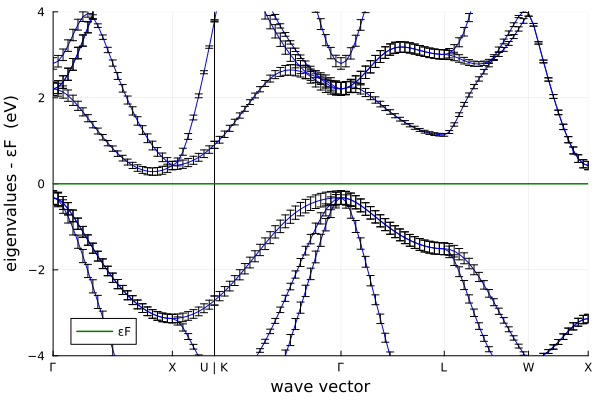

In [26]:
p1 = plot_bandstructure(
    (; bands..., eigenvalues_error=bands_uncertainty),
    unit=u"eV",
)

In [27]:
dbands_a = ForwardDiff.derivative(a -> bandstructure(a, params.θ_bf), a0)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450562080140                   -0.96    4.4    980ms
  2   -8.452298732649       -2.76       -1.48    1.0    987ms
  3   -8.452536096193       -3.62       -2.83    1.7    1.14s
  4   -8.452557926601       -4.66       -3.39    3.2    1.20s
  5   -8.452557969232       -7.37       -3.74    1.6    638ms
  6   -8.452557993834       -7.61       -4.26    2.4    713ms
  7   -8.452557995345       -8.82       -4.86    1.9    727ms
  8   -8.452557995465       -9.92       -5.24    1.7    807ms
  9   -8.452557995484      -10.72       -6.10    1.8    846ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      55.1   1.62s  Non-interacting
   1        0       1       -0.86     39.1   2.01s  
   2        0       2       -2.63     33.2   

17×109 Matrix{Float64}:
  0.0608389   0.06077     0.0605637   …   0.0223133    0.0223794
 -0.0118041  -0.0129277  -0.0155661       0.0223133    0.0223794
 -0.0118041  -0.0113123  -0.00999043      0.0168291    0.0163953
 -0.0118041  -0.0113123  -0.00999043      0.0168291    0.0163953
 -0.0158268  -0.0156408  -0.0150985       0.00869275   0.00922265
 -0.0158268  -0.0163981  -0.0179567   …   0.00869275   0.00922265
 -0.0158268  -0.0163981  -0.0179567      -0.099798    -0.101635
 -0.131627   -0.130506   -0.127807       -0.099798    -0.101635
 -0.0177893  -0.0172211  -0.015731       -0.0480174   -0.0459783
 -0.0177893  -0.0178506  -0.0180344      -0.0480174   -0.0459783
 -0.0520487  -0.0523257  -0.0531398   …  -0.0583889   -0.0530378
 -0.0469155  -0.0469998  -0.0472503      -0.0583889   -0.0530378
 -0.0469155  -0.0469998  -0.0472503      -0.135653    -0.141121
 -0.0469155  -0.0473235  -0.0484028      -0.135653    -0.141121
 -0.0763574  -0.0767764  -0.0780345      -0.0998426   -0.100684
 -0.

In [28]:
bands_uncertainty_total = [
    norm.(eachrow((dbands_reshaped[:,ik,:] + dbands_a[:,ik] * lattice_constant_gradient') * params.L))
    for ik in 1:size(b,2)
]

109-element Vector{Vector{Float64}}:
 [0.011713191820292238, 0.007189861673779805, 0.007189861785013947, 0.007189861702057392, 0.009106273780622256, 0.009106274114473692, 0.009106273686759786, 0.03340632042182838, 0.009774850728400826, 0.00977485078275307, 0.006874283501519238, 0.008461104748853249, 0.008461104883174711, 0.008461104836282356, 0.011076255670675892, 0.02792110233554883, 0.027921103217140975]
 [0.011696577460518236, 0.007358408924593673, 0.007063358926927485, 0.007063358927463232, 0.008968573844595722, 0.009174500398327757, 0.00917450045504465, 0.03312932413242553, 0.00940618790318119, 0.009788897432098168, 0.006778499457012476, 0.00848496583001704, 0.008484965866244995, 0.008577804036552924, 0.011011132052630037, 0.028204094640589723, 0.028204091505617798]
 [0.011646790453423275, 0.007787425578748894, 0.006729159488653032, 0.006729159488709253, 0.008575660531249087, 0.009377851445788758, 0.00937785149590441, 0.032461840814307065, 0.00845715047745672, 0.009831043060122556

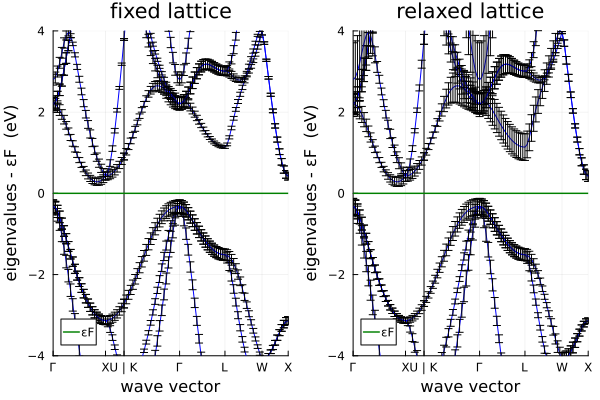

In [29]:
let
    p1 = plot_bandstructure(
        (; bands..., eigenvalues_error=bands_uncertainty),
        unit=u"eV",
    )
    p2 = plot_bandstructure(
        (; bands..., eigenvalues_error=bands_uncertainty_total),
        unit=u"eV",
    )

    # ylims = (-15, 10)
    # Plots.ylims!(p1, ylims)
    # Plots.ylims!(p2, ylims)
    plot(
        p1, p2,
        title = ["fixed lattice" "relaxed lattice"],
    )
end

## Sampling

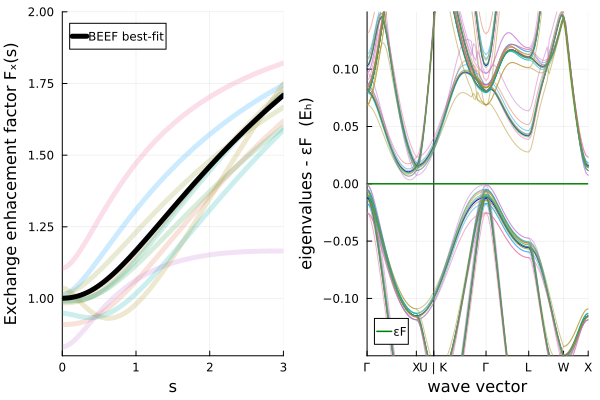

In [30]:
let 
    params = params_beef_2005()
    rng = MersenneTwister(1234)
    n_samples = 10
    α = randn(rng, 3, n_samples)
    δθ_ensemble = params.L * α
    fig_fx_ensemble = plot(xlim=(0,3), ylim=(0.8, 2.0), xlabel="s", ylabel="Exchange enhacement factor Fₓ(s)")
    for (i, δθ) in enumerate(eachcol(δθ_ensemble))
        plot!(fig_fx_ensemble, s -> f_x_beef(s, params.θ_bf + δθ), label=nothing,
        color=i, 
        linealpha=0.2, 
        lw=5)
    end
    plot!(fig_fx_ensemble, s -> f_x_beef(s, params.θ_bf), label="BEEF best-fit",
          linewidth=5, color=:black)

    p = plot_bandstructure(
        (; bands..., 
            # eigenvalues_error=bands_uncertainty_total
        ),
        plot_kwargs=(; color=:black)
        # unit=u"eV",
    )
    data = DFTK.data_for_plotting(bands)

    n_bands = size(dbands_reshaped, 1)

    for (i, δθ) in enumerate(eachcol(δθ_ensemble))
        δa0 = dot(lattice_constant_gradient, δθ)
        for σ = 1:data.n_spin, iband = 1:n_bands, branch in data.kbranches
            energies = (data.eigenvalues[:, iband, σ][branch] .- bands.εF) + (
                dbands_reshaped[iband,branch,:]*δθ + dbands_a[iband,branch] * δa0
            )
            plot!(p, data.kdistances[branch], energies, label="", color=i, 
                linealpha=0.5
            )
        end
    end


    plot(fig_fx_ensemble, p, layout=(1,2))
end